# Deep Leakage from Gradient Experiment - SAP + DP
This experiment will use the model and algorithm provided by the [Deep Leakage paper](https://arxiv.org/pdf/1906.08935) and [repository](https://github.com/mit-han-lab/dlg/tree/master?tab=readme-ov-file) on top of a generalised Federated Learning workflow taken from FlowerAI's example [documentation](https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html).


## Initialise Virtual environment
This will install the `virtualenv` command to then be run to create the virtual environment. The Python Script will add it to the Colab path and `source venv/bin/activate` should activate the virtual environment.

In [1]:
!rm -r venv/ 2>/dev/null
!rm -r gradients/ 2>/dev/null
!pip install -q virtualenv
!virtualenv venv
import os
os.environ['VIRTUAL_ENV'] = './venv'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['VIRTUAL_ENV'], 'bin')
!source venv/bin/activate

created virtual environment CPython3.11.11.final.0-64 in 870ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.0.1, setuptools==75.8.0, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


## Download Dependencies
These are the basic dependencies that can be found on FlowerAI's quickstart guide here.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Install-dependencies

In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

## Importing libraries
These Imports are taken from a mixture of a Github examples and their quick-start guide. It has been adapted with aditional imports that help with image metrics and gradient storing.

**CITE**: https://github.com/adap/flower/tree/main/examples/quickstart-pytorch

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Install-dependencies

**CITE**: https://github.com/adap/flower/blob/main/examples/fl-dp-sa/fl_dp_sa/client_app.py#L6C29-L6C46

In [16]:
# For task.py
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

# For client_app.py
import torch
from flwr.client import ClientApp, NumPyClient, Client
from flwr.common import Context
from flwr.client.mod import secaggplus_mod, fixedclipping_mod

# For server_app.py
from typing import List, Tuple

from flwr.common import Context, Metrics, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig, Grid, LegacyContext
from flwr.server.strategy import FedAvg, Strategy, DifferentialPrivacyClientSideFixedClipping
from flwr.server.workflow import SecAggPlusWorkflow, DefaultWorkflow
from flwr.simulation import run_simulation, start_simulation

# General imports
from datasets.utils.logging import disable_progress_bar
import flwr
from flwr.common import parameters_to_ndarrays
import numpy as np
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
import uuid
import pickle
from typing import Callable
import glob
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}/ Numpy {np.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.17.0 / PyTorch 2.6.0+cu124/ Numpy 2.0.2


## Task

### Initialise Client/Batch/Dataset

 This example is also tweaked from the original quickstart example to load the [CIFAR100 dataset](https://huggingface.co/datasets/uoft-cs/cifar100):
 - Initialises batch size for images and the number of available clients in the simulation.
 - Loads the `cifar100` dataset from `FederateDataset` and partitions based on number of clients.
 - Split the data with 80/20 train and test split.
 - Normalise and convert to tensors, if not alreary a tensor.
 - Batach apply transformations.
 - Load into training, testing and validation variables of type `DataLoader` to then be returned to the place that calls this function.


 **CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html

 **CITE**: https://huggingface.co/datasets/uoft-cs/cifar100

In [4]:
NUM_CLIENTS = 10
BATCH_SIZE = 100

def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="uoft-cs/cifar100", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader


### Example images from dataset
This was taken and tweaked from the documentation, where it loads and shows 32 CIFAR100 images. In this case the `["label"]` from the CIFAR10 dataset had to be switched to `["fine_label"]` to prevent any errors when loading these images.

A useful showcase of how the dataset is formatted.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Load-the-data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

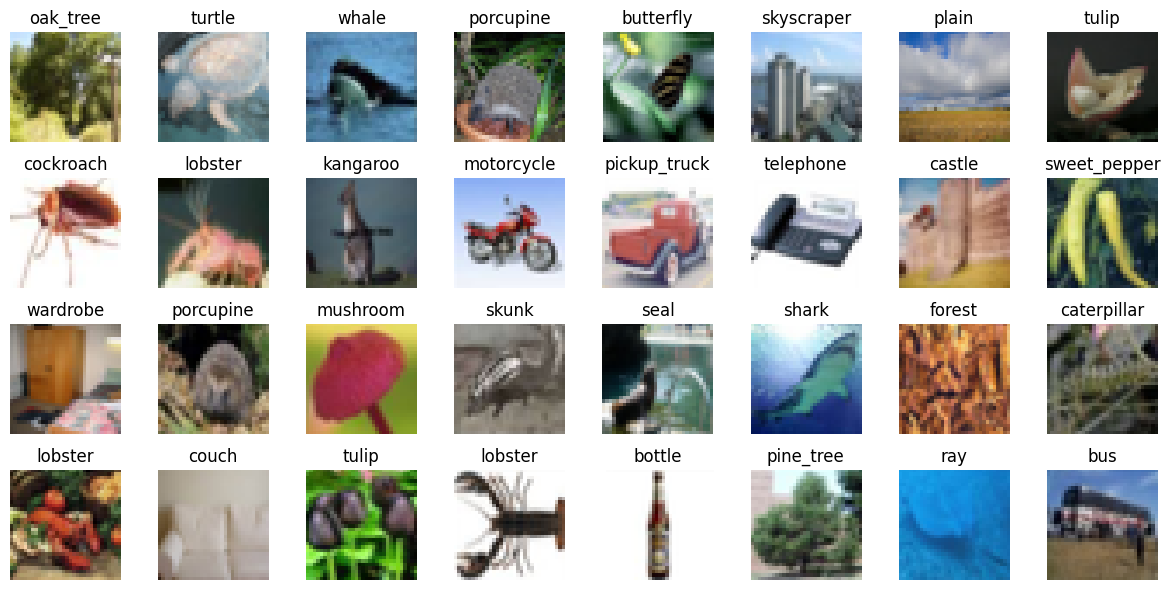

In [5]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["fine_label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["fine_label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

### Create Neural Network

This was taken from the DLG implementation, rather than creating a new one or using FlowerAI's example [one](https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-model). This was due to the model having been already showcased in this context, and the FlowerAI used Rectified Linear Unit (ReLU) activation function, which is not double differentiable. This makes it hard to run the attack.

**CITE**: https://github.com/mit-han-lab/dlg/blob/master/models/vision.py

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-model

In [6]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


### Train and Test functions
Running a basic training and testing function.

Right now, the `EPOCH` is set to `1` so it is not very effective, generally but is fine for this use-case.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Step-1:-Centralized-Training-with-PyTorch

In [7]:
def train(net, trainloader, epochs: int,verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["fine_label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["fine_label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predicted, average='weighted', zero_division=0)
    print(f"Test Loss: {loss}, Accuracy: {correct/total}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    return loss, accuracy, precision, recall, f1

## Client App

### Set up get parameter fetching and setting
These getter and setter methods for parameter access and update.

They are called in the `fit` function in the `FlowerClient` class, and they are used to alter and retrieve the Neural Network parameters, which can be used to access gradients.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Update-model-parameters

In [9]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Creating Client Strategy
This class was templated and tweaked from FlowerAI's documentation.

The added function is:
- `def store_gradients`: function to store `.pkl` files of gradients retrieved after training has occurred.

The added class variables are:
- `client_id`: generates a `uuid.uuid4()` string to prevent name duplications in file creation.
- `gradient_file`: f-string to for file creation.
- `gradient_file_path`: full file path to store.
- `clipping_norm`: maximum allowed norm for gradient before it gets clipped.
- `sensitivity`: maximum amount the output can change when data is added or removed from datset.
- `epsilon`: controls level of privacy.
- `delta`: probability that the privacy guaranatee of `epsilon` will not hold, hence very small.

The idea, in this example is to "steal" gradients before any additional forms of PET were implemented on them. In this case however it is not called as SAP + DP will be tested with provided `mods` and `Workflows` by FlowerAI.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-Flower-ClientApp


In [10]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_id = str(uuid.uuid4())
        self.gradient_file = f"gradients_{self.client_id}.pkl"
        os.makedirs("gradients", exist_ok=True)
        self.gradient_file_path = os.path.join("gradients", self.gradient_file)


    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def store_gradients(self):
        batch_gradients = [param.grad.detach().cpu() for param in self.net.parameters() if param.grad is not None]
        with open(self.gradient_file_path, "ab") as f:
            pickle.dump(batch_gradients, f)

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy, precision, recall, f1 = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1_score": float(f1)
        }

### Create and initialise client
Simple function to create and initialise the `Client` class to be used in the simulation.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-Flower-ClientApp

**CITE**: https://github.com/adap/flower/blob/main/examples/fl-dp-sa/fl_dp_sa/client_app.py#L48

In [11]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = LeNet().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()



# Create the ClientApp
client = ClientApp(
    client_fn=client_fn,
      mods=[
        secaggplus_mod,
        fixedclipping_mod,
    ],
)

## Server App
Create a basic `FedAvg` strategy.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-Flower-ServerApp

### Store the SAP encrypted gradient here

Here this strategy:

- Inherits from `FedAvg`.
- Runs inherited `aggregate_fit` function.
- Checks if `aggregate_parameters` is not empty
- Quickly runs a dummy pass of network to then store gradient, same as `FlowerClient

**CITE**: https://github.com/adap/flower/blob/main/src/py/flwr/server/strategy/fedavg.py#L52

In [12]:
class GradientTrackingStrategy(FedAvg):
      def __init__(self, *args, **kwargs):
          super().__init__(*args, **kwargs)
          self.net = None
          self.server_id = str(uuid.uuid4())
          self.gradient_file = f"gradients_{self.server_id}.pkl"
          os.makedirs("gradients", exist_ok=True)
          self.gradient_file_path = os.path.join("gradients", self.gradient_file)

      def store_gradients(self):
        batch_gradients = [param.grad.detach().cpu() for param in self.net.parameters() if param.grad is not None]
        with open(self.gradient_file_path, "ab") as f:
            pickle.dump(batch_gradients, f)

      def aggregate_fit(self, server_round, results, failures):
        if len(results) == 0:
            return None
        aggregated_parameters, metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            aggregated_parameters = parameters_to_ndarrays(aggregated_parameters)
            self.net.train()
            set_parameters(self.net, aggregated_parameters)
            # Perform a dummy forward and backward pass to calculate gradients of net once aggregate has been set
            dummy_input = torch.randn(1, 3, 32, 32).to(DEVICE)  # Adjust input shape as needed
            dummy_output = self.net(dummy_input)
            dummy_loss = dummy_output.sum()  # A dummy loss function
            dummy_loss.backward()
            self.store_gradients()
            aggregated_parameters = ndarrays_to_parameters(aggregated_parameters)
        return aggregated_parameters, metrics

### Create and initialise server
Setting up the configuration so that the Federated Learning workflow runs for 3 rounds, which can be adjusted.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Define-the-Flower-ServerApp

In [13]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    return ServerAppComponents()
# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run Training


#### Set Backend Config
Backend configuration about resources that can be used when running this workflow.

**CITE**: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html#Run-the-training

In [14]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

#### Run a simulation based on provided config
Due to the inclusion of the `SecAggPlusWorkflow` a function with the `@server.main()` decorator had to pass said workflow rather than directly passing it to the `SeverApp`.


**CITE**: https://github.com/adap/flower/blob/68e24206fd4754a9047914b318977b293d990e03/examples/flower-secure-aggregation/secaggexample/server_app.py#L31

In [23]:
@server.main()
def main(grid: Grid, context: Context) -> None:
    # Define strategy with altered aggregate fit to capture gradient serverside
    #strategy = GradientTrackingStrategy(
    #fraction_fit=1.0,  # Sample 100% of available clients for training
    #fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    #min_fit_clients=10,  # Never sample less than 10 clients for training
    #min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    #min_available_clients=10,  # Wait until all 10 clients are available
    #)

    gradient_tracking_strategy = GradientTrackingStrategy(
          fraction_fit=1.0,  # Sample 100% of available clients for training
          fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
          min_fit_clients=10,  # Never sample less than 10 clients for training
          min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
          min_available_clients=10,  # Wait until all 10 clients are available
    )





    net = LeNet().to(DEVICE)  # Create an instance of the model
    initial_parameters = ndarrays_to_parameters(
        [val.cpu().numpy() for _, val in net.state_dict().items()]
    )
    if gradient_tracking_strategy.net is None:
        gradient_tracking_strategy.net = net
    gradient_tracking_strategy.initial_parameters = initial_parameters  # Set the initial parameters


    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy=gradient_tracking_strategy,
        noise_multiplier=1.5,
        clipping_norm=1.0,
        num_sampled_clients=NUM_CLIENTS,
    )



    context = LegacyContext(
        context=context,
        config=ServerConfig(num_rounds=3),
        strategy=strategy,
    )

    fit_workflow = SecAggPlusWorkflow(
            num_shares=5,
            reconstruction_threshold=3,
    )

    # Create the workflow
    workflow = DefaultWorkflow(fit_workflow=fit_workflow)

    # Execute
    workflow(grid, context)
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      Secure aggregation commencing.
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=14316) 2025-03-30 16:14:02.567823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14316) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=14316) E0000 00:00:1743351242.629566   14316 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14316) E0000 00:00:1743351242.644280   14316 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBL

(ClientAppActor pid=14316) Test Loss: 0.05606118202209473, Accuracy: 0.013, Precision: 0.0002425207488901756, Recall: 0.013, F1: 0.0004760566324812135


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      Secure aggregation commencing.
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14316) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 4x across cluster]
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 3x across cluster]
(ClientAppActor pid=14316) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 2x across cluster]
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggre

(ClientAppActor pid=14317) Test Loss: 0.06329539966583252, Accuracy: 0.009, Precision: 8.14070351758794e-05, Recall: 0.009, F1: 0.0001613545816733068 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      Secure aggregation commencing.
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14316) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14316) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 3x across cluster]
(ClientAppActor pid=14317) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.1500 stdev added
INFO : 

(ClientAppActor pid=14316) Test Loss: 0.06666749572753906, Accuracy: 0.008, Precision: 0.0005847018463769734, Recall: 0.008, F1: 0.001050950835612935 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 134.69s
INFO :      History (loss, distributed):
INFO :      		round 1: 0.055603197669982916
INFO :      		round 2: 0.0629381742477417
INFO :      		round 3: 0.0662068383216858
INFO :      


(ClientAppActor pid=14316) Test Loss: 0.06653884983062744, Accuracy: 0.008, Precision: 0.00046002442533543014, Recall: 0.008, F1: 0.0008654224610687744 [repeated 4x across cluster]


(ClientAppActor pid=14316) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


## DLG

### First collect all gradients that have been simulated as captured.
Load all the captureed gradients as `.pkl` files for usage in the Deep Leakage from Gradients attack.

In [24]:
def load_captured_gradients(path="gradients"):
    all_gradients = []
    gradient_pkl_files = glob.glob(os.path.join(path, "*.pkl"))
    for gradient_pkl_file in gradient_pkl_files:
        with open(gradient_pkl_file, "rb") as f:
            gradients = pickle.load(f)
            all_gradients.extend(gradients)
    print(f"Loaded {len(all_gradients)} gradients from {path}/")
    return all_gradients

loaded_gradients = load_captured_gradients()

Loaded 8 gradients from gradients/


### Setup for functions for DLG attack
Original setup with little alterations on gradient access.

#### Helper functions for tensor maths and conversions
**CITE**: https://github.com/mit-han-lab/dlg/blob/master/utils.py#L5


In [25]:
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

#### Loading Dataset
Dataset is loaded alongside:
- `tp`: `transforms.ToTensor()`: used to convert a `PIL.Image` to `Tensor`.
- `tt`: `transforms.ToPILImage()`: used to convert file `Tensor` to `PIL.Image`.

**CITE**: https://github.com/mit-han-lab/dlg/blob/master/main.py#L31

In [26]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

100%|██████████| 169M/169M [00:01<00:00, 105MB/s]


#### Set up ground truth
In an ideal scenario you would iterate over the full dataset until you get the ground truth with the highest structural similarity but that will not be the case here.

**CITE**: https://github.com/mit-han-lab/dlg/blob/master/main.py#L35

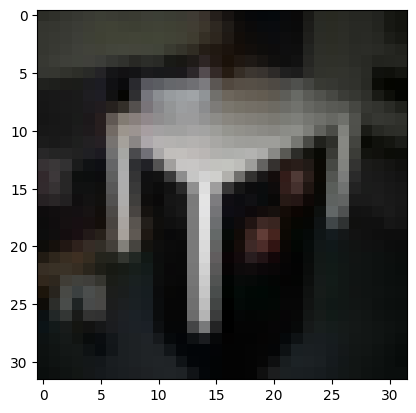

In [27]:
img_index = 25
gt_data = tp(dst[img_index][0]).to(DEVICE)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(DEVICE)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

plt.imshow(tt(gt_data[0].cpu()))

#### Initialise Neural Network
- Use Neural Network that was used for training.
- Set a `manual_seed` for reproducibility.
- Generate a new randomly initialised gradient and plot it.

**CITE**: https://github.com/mit-han-lab/dlg/blob/master/main.py#L50

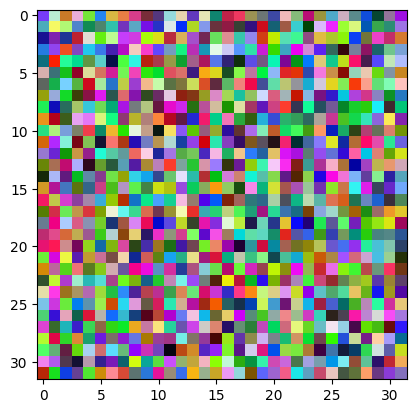

In [28]:
net = LeNet().to(DEVICE)

torch.manual_seed(1234)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

dummy_data = torch.randn(gt_data.size()).to(DEVICE).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(DEVICE).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))

#### Train
Now train as shown in the DLG repository. The function was altered as the original provided a closer match in type and shape of gradient wheras this does not.

**CITE**: https://github.com/mit-han-lab/dlg/blob/master/main.py#L72

0 0.0056
10 0.0037
20 0.0037
30 0.0037
40 0.0037
50 0.0037
60 0.0037
70 0.0037
80 0.0037
90 0.0037
100 0.0037
110 0.0037
120 0.0037
130 0.0037
140 0.0037
150 0.0037
160 0.0037
170 0.0037
180 0.0037
190 0.0037
200 0.0037
210 0.0037
220 0.0037
230 0.0037
240 0.0037
250 0.0037
260 0.0037
270 0.0037
280 0.0037
290 0.0037


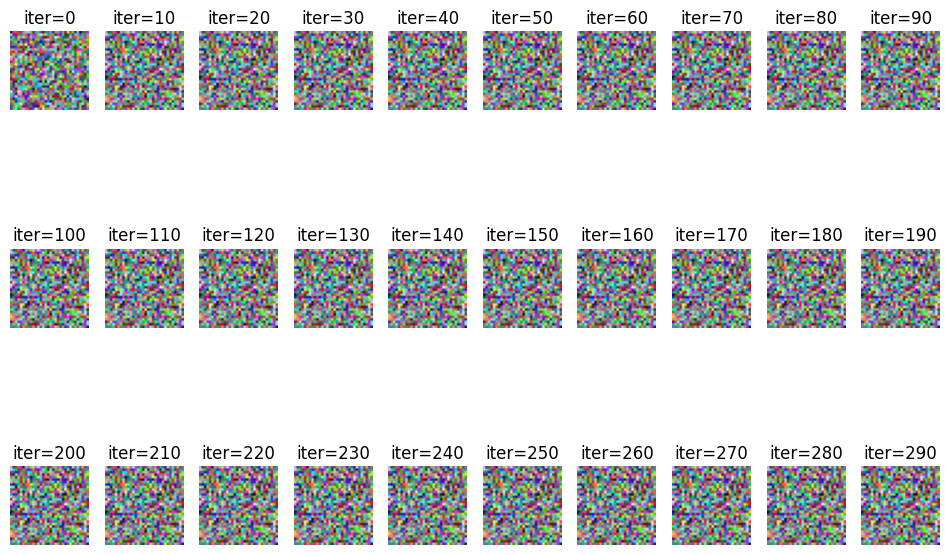

In [29]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        original_dy_dx = [dy_dx for dy_dx in loaded_gradients if dy_dx.shape == dummy_dy_dx[0].shape]
        original_dy_dx = original_dy_dx[0]

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx[0], original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))


plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()

## Compare metrics
This takes both the ground truth (`gt`) and reconstructed image (`reconstructed`) and convert them into `ndarray`'s to then be compared by the MSE, PSNR and SSIM metrics.

Though this result is not as pleasing as the one in the original paper there are many reasons for this:
- They use a centralised approach with prior knowledge as to what the ground truth is.
- They train on said ground truth's gradient provide a more reasonable representation.
- This could be further expanded in this case to loop through the full dataset.
  - Though it would produce a run time of O(n×m)
  - Where n is dataset size and m is training epoch.

In [30]:
gt = np.array(tt(gt_data[0].cpu()))
reconstructed = np.array(history[-1])
gt = (gt_data[0].cpu().numpy() * 255).astype(np.uint8)
reconstructed = (reconstructed * 255).astype(np.uint8)
gt = gt.transpose(1, 2, 0)
mse = mean_squared_error(gt, reconstructed)
psnr = peak_signal_noise_ratio(gt, reconstructed)
ssim, _ = structural_similarity(gt, reconstructed, full=True, win_size=3)


print(f"MSE: {mse}")
print(f"PSNR: {psnr}")
print(f"SSIM: {ssim}")

MSE: 13718.7607421875
PSNR: 6.7576547888038805
SSIM: -0.0012108023230896327
